In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in note"book, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT


This notebook is the second attempt to read in track information and use it to predict the KDE used as input to PvFinder. This time, we are reading in poca KDEs rather than the original KDEs. 

collectdata_kde_C.py uses poca_z, poca_x, poca_y, major_axis_x, major_axis_y, and major_axis_z as the six track parameters (for the moment)


Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Fri Dec 25 21:38:59 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 450.36.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:18:00.0 Off |                  N/A |
| 29%   39C    P8    40W / 250W |   6932MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:3B:00.0 Off |                  N/A |
| 29%   

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

This notebook is first attempt to read in track information and use it to predict the KDE used as input to PvFinder.


## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd

# Python 3 standard library
from pathlib import Path

##from torchsummary import summary

### Set up local parameters

In [4]:
n_epochs = 800

# Name is the output file name


##  201027 -- about to go to bed, so try 2500 epochs with lr = 1e55
##  previous iteration had l4 = 3e-5 and cost dropped almost linearly
##  for 100 epochs -- final training costs ~ 2.02, validation cost ~ 2.01

## for iter 4, try 10 epochs with lr = 3e-6
## usually have a big jump down at epoch 0; want to try a
## small number of epochs per iteration and see what happens (iter4: 10 epochs gave
## traiing cost dropping from 1.54 to 1.50 immediately, then dropping very slowly)
folder = '25December__DDplus_loss_Ba_iter5_floatAll_800epochs_1em5'
name   = folder

# Make an output folder named "name" (change if you want)

## Special instructions for those working on goofy at UC
## Please be very careful to make sure that your folder
## does not live in a subdirectory of your home directory
## this disk has very little capacity. Instead, use 
## a subdirectory in /share/lazy with a symbolic link to
## it in this (the notebooks) subdirectory
folder = 'ML/' + folder
output = Path(folder)


# Size of batches
batch_size = 16 ## was 64
# How fast to learn
learning_rate = 1e-5

Make the output directory if it does not exist:

In [5]:
output.mkdir(exist_ok=True)

## Get the helper functions

Add the directory with the model
definitions to the path so we can import from it:

> When you type `import X`,
Python searches `sys.path` for a python
file named `X.py` to import. So we need to add the model directory to the path.

In [6]:
# From model/collectdata.py
##from model.collectdata_kde_B import collect_t2kde_data
## collectdata_kde_C should use the new poca KDE rather than the original kernel KDE
from model.collectdata_kde_Ellipsoids import collect_t2kde_data


# From model/loss.py
##from loss import Loss
## kde_loss_D includes botha ratio term and a chisq term, 98% ave_chisq
## kde_loss_E adds a chi^4 term to the kde_loss_D return value
## this is intended to emphasize the importance of values significantly different than zero
from model.kde_loss_Ba import Loss

##  TracksToKDE_Ellipsoids_SevenLayerCake has 7 hidden layers producing the 4000-bin KDE historgram
##  It takes 9 input features (pocca centers + (A,B,C,D,E,F) . 
from model.models_kde import TracksToKDE_Ellipsoids_DDplus as Model


from model.training_kde import trainNet, select_gpu, Results
from model.plots import dual_train_plots, replace_in_ax

In [7]:
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [8]:
device = select_gpu(0)
##device = "cpu"

1 available GPUs (initially using device 0):
  0 GeForce RTX 2080 Ti


## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [9]:
##print("Let's use", torch.cuda.device_count(), "GPUs!")
##if torch.cuda.device_count() > 1:
##    model = torch.nn.DataParallel(model)

In [10]:
## a comment on the web at https://pytorch.org/docs/stable/optim.html says
"""
If you need to move a model to GPU via .cuda(), please do so before constructing optimizers for it. 
Parameters of a model after .cuda() will be different objects with those before the call.

In general, you should make sure that optimized parameters live in consistent locations when 
optimizers are constructed and used.
"""
## so move this here (although we are using model.to(device) not explicitly using .cuda()

nOut1 = 50
nOut2 = 50
nOut3 = 50
nOut4 = 50
nOut5 = 50
nOut6 = 50
nOut7 = 50
nOut8 = 50
nOut9 = 50
nOut10 = 50
nOut11 = 50
latentChannels = 4
model = Model(nOut1,nOut2,nOut3,nOut4,nOut5,nOut6,nOut7,nOut8,nOut9,nOut10,nOut11,latentChannels)

##summary(model, input_size=(4, 4000))
##print(model.parameters)

## add the following code to allow the user to freeze the some of the weights corresponding 
## to those taken from an earlier model trained with the original target histograms
## presumably -- this leaves either the perturbative filter "fixed" and lets the 
## learning focus on the non-perturbative features, so get started faster, or vice versa
ct = 0
for child in model.children():
  print('ct, child = ',ct, "  ", child)
  if ct < 0:
    print("     About to set param.requires_grad=False for ct = ", ct, "params")
    for param in child.parameters():
        param.requires_grad = False 
  ct += 1
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
##  loss = Loss(epsilon=1e-5,coefficient=2.5)
##loss = Loss(epsilon=3e-5, debug=False)
loss = Loss(epsilon=3e-5)

ct, child =  0    Linear(in_features=9, out_features=50, bias=True)
ct, child =  1    Linear(in_features=50, out_features=50, bias=True)
ct, child =  2    Linear(in_features=50, out_features=50, bias=True)
ct, child =  3    Linear(in_features=50, out_features=50, bias=True)
ct, child =  4    Linear(in_features=50, out_features=50, bias=True)
ct, child =  5    Linear(in_features=50, out_features=50, bias=True)
ct, child =  6    Linear(in_features=50, out_features=50, bias=True)
ct, child =  7    Linear(in_features=50, out_features=50, bias=True)
ct, child =  8    Linear(in_features=50, out_features=50, bias=True)
ct, child =  9    Linear(in_features=50, out_features=50, bias=True)
ct, child =  10    Linear(in_features=50, out_features=50, bias=True)
ct, child =  11    Linear(in_features=50, out_features=16000, bias=True)
ct, child =  12    Conv1d(4, 25, kernel_size=(25,), stride=(1,), padding=(12,))
ct, child =  13    Conv1d(25, 1, kernel_size=(5,), stride=(1,), padding=(2,))
ct, child 

Let's move the model's weight matricies to the GPU:

In [11]:
model = model.to(device)

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
##optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [13]:
print('output = ',output)
##print('oldOutput = ',oldOutput)
##  use the first four layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113

##   ML -> /share/lazy/sokoloff/ML
model_dict = model.state_dict()
## mds 190725 for debugging
print("for model_dict")
index = 0
for k,v in model_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
##    print("value = ", v)
 
updated_dict = model_dict
##print("updated_dict = ",updated_dict)
## when starting "ab initio", reduce biases as the bias gets summed for each track
## contributing to the predicted KDE
updated_dict["layer1.bias"] = 0.005*model_dict["layer1.bias"]
updated_dict["layer2.bias"] = 0.005*model_dict["layer2.bias"]
updated_dict["layer3.bias"] = 0.005*model_dict["layer3.bias"]
updated_dict["layer4.bias"] = 0.005*model_dict["layer4.bias"]
updated_dict["layer5.bias"] = 0.005*model_dict["layer5.bias"]
updated_dict["layer6.bias"] = 0.005*model_dict["layer6.bias"]
updated_dict["layer7.bias"] = 0.005*model_dict["layer7.bias"]
updated_dict["layer8.bias"] = 0.005*model_dict["layer8.bias"]
updated_dict["layer9.bias"] = 0.005*model_dict["layer9.bias"]
updated_dict["layer10.bias"] = 0.005*model_dict["layer10.bias"]
updated_dict["layer11.bias"] = 0.005*model_dict["layer11.bias"]

model.load_state_dict(updated_dict,strict=False)

model_dict = model.state_dict()
##print("updated model_dict = ",model_dict)

## print(" \n","  for pretrained_dict")
## index = 0
##for k,v in pretrained_dict.items():
##    print("index, k =  ",index,"  ",k)
##    index = index+1
## mds  

##pretrained_dict = torch.load('ML/29July2020_Trks_to_KDE_C_lossB_100epochs_b64_1m3_nOut_50x50/29July2020_Trks_to_KDE_C_lossB_100epochs_b64_1m3_nOut_50x50_final.pyt')
##print("model_dict instantiated")
# 1. filter out unnecessary keys
##pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
##print("pretrained_dict iterated")
# 2. overwrite entries in the existing state dict
##model_dict.update(pretrained_dict) 
##
#   when starting from a model with a fully connected last layer rather than a convolutional layer
# 3. load the new state dict
#   need to use strict=False as the two models state model attributes do not agree exactly
#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

##model.load_state_dict(pretrained_dict,strict=False)

## print('model_dict =    ', model_dict)

## finished at training cost = 1.46, validation cost = 1.50
d_folder = '25December__DDplus_loss_Ba_iter4_floatAll_500epochs_1em5'
d_name = d_folder
suffix = 'final'
dict_name = 'ML/' + d_folder + '/' + d_name + '_'+ suffix + '.pyt'
print('dict_name = ',dict_name)
pretrained_dict = torch.load(dict_name)

print(" ")
print("  for pretrained_dict")
index = 0
for k,v in pretrained_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
 

##print("model_dict instantiated")
# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
print("pretrained_dict iterated")
# 2. overwrite entries in the existing state dict
model_dict.update(pretrained_dict) 
##
#   when starting from a model with a fully connected last layer rather than a convolutional layer
# 3. load the new state dict
#   need to use strict=False as the two models state model attributes do not agree exactly
#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

model.load_state_dict(pretrained_dict,strict=False)



output =  ML/25December__DDplus_loss_Ba_iter5_floatAll_800epochs_1em5
for model_dict
index, k =   0    layer1.weight
index, k =   1    layer1.bias
index, k =   2    layer2.weight
index, k =   3    layer2.bias
index, k =   4    layer3.weight
index, k =   5    layer3.bias
index, k =   6    layer4.weight
index, k =   7    layer4.bias
index, k =   8    layer5.weight
index, k =   9    layer5.bias
index, k =   10    layer6.weight
index, k =   11    layer6.bias
index, k =   12    layer7.weight
index, k =   13    layer7.bias
index, k =   14    layer8.weight
index, k =   15    layer8.bias
index, k =   16    layer9.weight
index, k =   17    layer9.bias
index, k =   18    layer10.weight
index, k =   19    layer10.bias
index, k =   20    layer11.weight
index, k =   21    layer11.bias
index, k =   22    layer12new.weight
index, k =   23    layer12new.bias
index, k =   24    conv1.weight
index, k =   25    conv1.bias
index, k =   26    conv2.weight
index, k =   27    conv2.bias
index, k =   28    fc

<All keys matched successfully>

In [14]:
##print('validation.dataset.tensors = ',validation.dataset.tensors)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

In [15]:

## Training dataset. You can put as many files here as desired.

##train_loader = collect_t2kde_data('/share/lazy/pv-finder/20k_evts_for_KDE_learning_200716.h5',
train_loader = collect_t2kde_data('dataAA/20K_POCA_kernel_evts_200926.h5',
##train_loader = collect_t2kde_data('/share/lazy/pv-finder/test_data_for_KDE_learning_BastilleDay20.h5',
                            batch_size=batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
##                          device=device,
                           slice = slice(None,18000)
                           )
                            
# Validation dataset. You can slice to reduce the size.
## mds no separate validation set yet,
val_loader = collect_t2kde_data('dataAA/20K_POCA_kernel_evts_200926.h5',
                            batch_size=batch_size,
##                            device=device,
                            slice = slice(18000,None)
                           )


Loading data...
pocaMx.shape =  (20000,)
nEvts =  20000
len(pocaMx[0]) =  211
len(pocaMx[1]) =  21
len(pocaMx[2]) =  20
len(pocaMx[3]) =  198
len(pocaMx[4]) =  233
majorAxis.shape =  (20000, 3)
minorAxis_1.shape =  (20000, 3)
minorAxis_2.shape =  (20000, 3)
have entered six_ellipsoid_parameters
  
 
  nEvts =  20000
 iEvt, nTrks =  0 211
 iEvt, nTrks =  1 21
 iEvt, nTrks =  2 20
 iEvt, nTrks =  3 198
 iEvt, nTrks =  4 233
 iEvt, nTrks =  5 85
 iEvt, nTrks =  6 223
 iEvt, nTrks =  7 425
 iEvt, nTrks =  8 252
 iEvt, nTrks =  9 169
A.shape =  (20000,)
majorAxis[iTrk][0][0] =  -0.00023452607
majorAxis[iTrk][1][0] =  -0.00047206535
majorAxis[iTrk][2][0] =  0.096502915
minorAxis_1[iTrk][0][0] =  -15.822749
minorAxis_1[iTrk][1][0] =  7.8608756
minorAxis_1[iTrk][2][0] =  -2.6228399e-08
minorAxis_2[iTrk][0][0] =  7.860759
minorAxis_2[iTrk][1][0] =  15.822513
minorAxis_2[iTrk][2][0] =  0.096502915
  
majorAxis[iTrk][0][0] =  -0.37655562
majorAxis[iTrk][1][0] =  0.2768704
majorAxis[iTrk][2][0] = 

len(X) =  20000
len(Xlist) =  1
Loaded dataAA/20K_POCA_kernel_evts_200926.h5 in 28.37 s
outer loop X.shape =  (20000, 9, 600)
Constructing 2000 event dataset took 0.01359 s
x_t.shape =  torch.Size([2000, 9, 600])
x_t.shape[0] =  2000
x_t.shape[1] =  9
x_t.shape =  torch.Size([2000, 9, 600])


<IPython.core.display.Javascript object>


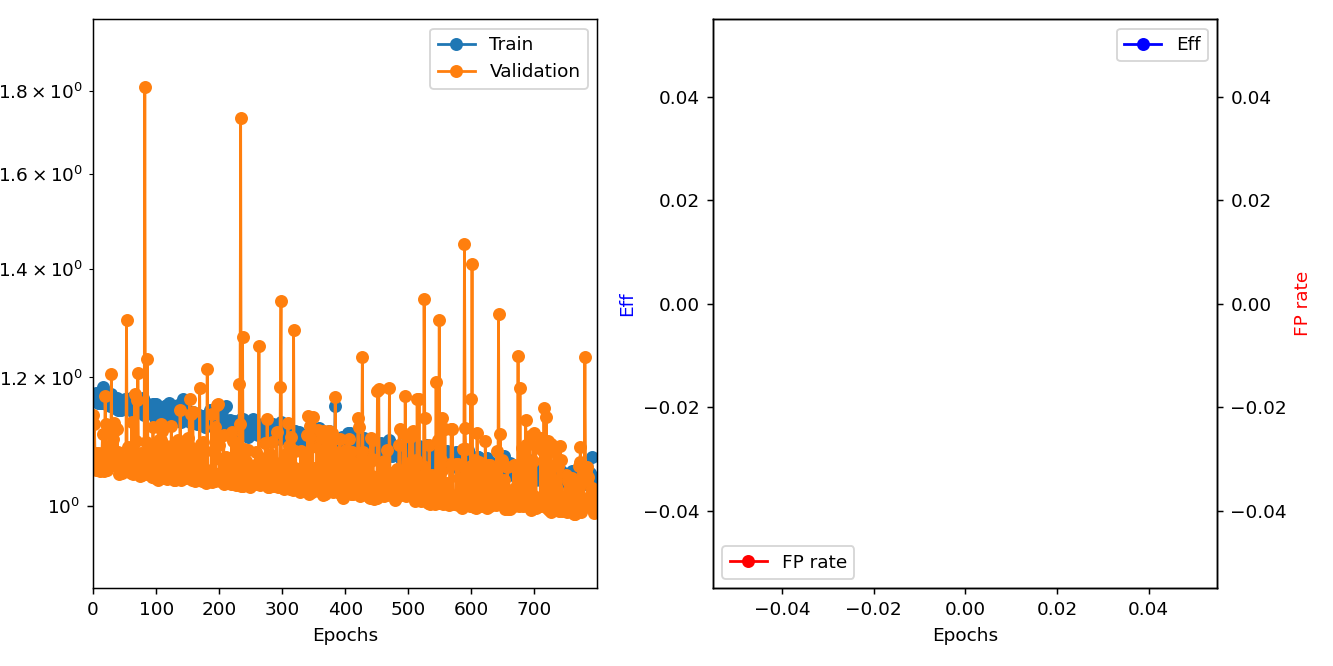

In [16]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()

In [17]:
for result in trainNet(model, optimizer, loss,
                        train_loader, val_loader,
                        n_epochs, epoch_start=len(results),
                        notebook=True):
    
    results = results.append(pd.Series(result._asdict()), ignore_index=True)
    xs = results.index
    
    # Update the plot above
    lines['train'].set_data(results.index,results.cost)
    lines['val'].set_data(results.index,results.val)
    
    #filter first cost epoch (can be really large)
    max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
    min_cost = min(min(results.cost), min(results.val))
    
    # The plot limits need updating too
    
    
    
    ax.set_ylim(min_cost*.9, max_cost*1.1)  
    ax.set_xlim(-.5, len(results.cost) - .5)

    
    # Redraw the figure
    fig.canvas.draw()

    # Save each model state dictionary
    torch.save(model.state_dict(), output / f'{name}_{result.epoch}.pyt')

Number of batches: train = 1125, val = 125


Number of batches: train = 1125, val = 125


Epoch 0: train=1.16537, val=1.1385, took 37.308 s


Epoch 1: train=1.16507, val=1.05409, took 36.979 s


Epoch 2: train=1.16003, val=1.12296, took 37.168 s


Epoch 3: train=1.16661, val=1.07832, took 37.146 s


Epoch 4: train=1.17424, val=1.07604, took 37.474 s


Epoch 5: train=1.1613, val=1.05239, took 37.062 s


Epoch 6: train=1.16545, val=1.06258, took 37.049 s


Epoch 7: train=1.1673, val=1.07839, took 37.117 s


Epoch 8: train=1.158, val=1.05844, took 37.021 s


Epoch 9: train=1.17438, val=1.06388, took 37.165 s


Epoch 10: train=1.16073, val=1.0764, took 37.092 s


Epoch 11: train=1.15969, val=1.05148, took 37.143 s


Epoch 12: train=1.16678, val=1.06995, took 37.203 s


Epoch 13: train=1.15735, val=1.0667, took 37.142 s


Epoch 14: train=1.15708, val=1.07817, took 37.212 s


Epoch 15: train=1.18435, val=1.10708, took 37.088 s


Epoch 16: train=1.1598, val=1.05419, took 36.944 s


Epoch 17: train=1.1611, val=1.05801, took 37.017 s


Epoch 18: train=1.16516, val=1.05147, took 37.027 s


Epoch 19: train=1.16458, val=1.16909, took 36.941 s


Epoch 20: train=1.15529, val=1.12392, took 37.019 s


Epoch 21: train=1.15941, val=1.05307, took 37.088 s


Epoch 22: train=1.15918, val=1.05282, took 37.088 s


Epoch 23: train=1.15365, val=1.07602, took 37.164 s


Epoch 24: train=1.16246, val=1.0694, took 36.963 s


Epoch 25: train=1.15624, val=1.05931, took 36.994 s


Epoch 26: train=1.16074, val=1.08891, took 36.972 s


Epoch 27: train=1.15209, val=1.113, took 36.989 s


Epoch 28: train=1.17197, val=1.06775, took 37.167 s


Epoch 29: train=1.15445, val=1.20568, took 36.975 s


Epoch 30: train=1.15272, val=1.07105, took 37.051 s


Epoch 31: train=1.15739, val=1.09993, took 36.894 s


Epoch 32: train=1.159, val=1.07161, took 36.844 s


Epoch 33: train=1.15483, val=1.12493, took 37.017 s


Epoch 34: train=1.15515, val=1.11355, took 36.963 s


Epoch 35: train=1.14866, val=1.11935, took 36.852 s


Epoch 36: train=1.163, val=1.07037, took 36.939 s


Epoch 37: train=1.15822, val=1.0581, took 37.017 s


Epoch 38: train=1.16505, val=1.11579, took 37.003 s


Epoch 39: train=1.15562, val=1.07999, took 36.912 s


Epoch 40: train=1.14537, val=1.07308, took 36.96 s


Epoch 41: train=1.1527, val=1.04666, took 36.986 s


Epoch 42: train=1.15478, val=1.05744, took 36.929 s


Epoch 43: train=1.15419, val=1.0491, took 36.92 s


Epoch 44: train=1.14685, val=1.05882, took 37.108 s


Epoch 45: train=1.15111, val=1.05986, took 36.857 s


Epoch 46: train=1.15358, val=1.04827, took 36.866 s


Epoch 47: train=1.1509, val=1.06346, took 37.007 s


Epoch 48: train=1.15559, val=1.06966, took 37.0 s


Epoch 49: train=1.15052, val=1.06325, took 36.858 s


Epoch 50: train=1.16321, val=1.0565, took 36.92 s


Epoch 51: train=1.16115, val=1.05917, took 36.934 s


Epoch 52: train=1.15078, val=1.0537, took 36.926 s


Epoch 53: train=1.14714, val=1.30121, took 36.921 s


Epoch 54: train=1.15583, val=1.05481, took 36.972 s


Epoch 55: train=1.1589, val=1.06074, took 36.936 s


Epoch 56: train=1.15104, val=1.08795, took 36.907 s


Epoch 57: train=1.15142, val=1.05523, took 36.923 s


Epoch 58: train=1.14616, val=1.05084, took 36.981 s


Epoch 59: train=1.15224, val=1.0587, took 36.973 s


Epoch 60: train=1.16553, val=1.04795, took 37.004 s


Epoch 61: train=1.14869, val=1.12622, took 37.02 s


Epoch 62: train=1.15757, val=1.06173, took 36.854 s


Epoch 63: train=1.15562, val=1.04672, took 36.909 s


Epoch 64: train=1.14582, val=1.06515, took 36.85 s


Epoch 65: train=1.14348, val=1.07194, took 37.028 s


Epoch 66: train=1.14906, val=1.17168, took 36.989 s


Epoch 67: train=1.15613, val=1.05598, took 37.148 s


Epoch 68: train=1.16079, val=1.09663, took 36.922 s


Epoch 69: train=1.14818, val=1.16241, took 36.973 s


Epoch 70: train=1.15644, val=1.05102, took 36.965 s


Epoch 71: train=1.15776, val=1.20773, took 36.922 s


Epoch 72: train=1.153, val=1.0587, took 36.846 s


Epoch 73: train=1.14908, val=1.04819, took 36.9 s


Epoch 74: train=1.14304, val=1.04443, took 36.868 s


Epoch 75: train=1.1487, val=1.05973, took 36.922 s


Epoch 76: train=1.15069, val=1.07842, took 36.965 s


Epoch 77: train=1.14477, val=1.05605, took 36.884 s


Epoch 78: train=1.14493, val=1.04483, took 37.085 s


Epoch 79: train=1.16491, val=1.07679, took 36.95 s


Epoch 80: train=1.14783, val=1.05901, took 36.805 s


Epoch 81: train=1.13875, val=1.06182, took 37.091 s


Epoch 82: train=1.15494, val=1.81072, took 37.121 s


Epoch 83: train=1.14371, val=1.06031, took 37.075 s


Epoch 84: train=1.15151, val=1.09522, took 37.135 s


Epoch 85: train=1.14522, val=1.04632, took 36.968 s


Epoch 86: train=1.14399, val=1.232, took 37.035 s


Epoch 87: train=1.15537, val=1.06378, took 36.873 s


Epoch 88: train=1.14147, val=1.08445, took 36.904 s


Epoch 89: train=1.15069, val=1.04639, took 36.928 s


Epoch 90: train=1.14079, val=1.05613, took 37.033 s


Epoch 91: train=1.1473, val=1.0488, took 37.014 s


Epoch 92: train=1.14576, val=1.06088, took 36.977 s


Epoch 93: train=1.14643, val=1.04212, took 36.967 s


Epoch 94: train=1.15161, val=1.06977, took 37.076 s


Epoch 95: train=1.1555, val=1.11866, took 36.938 s


Epoch 96: train=1.15506, val=1.04802, took 36.878 s


Epoch 97: train=1.14307, val=1.0631, took 36.984 s


Epoch 98: train=1.13258, val=1.04126, took 37.145 s


Epoch 99: train=1.14417, val=1.04672, took 37.06 s


Epoch 100: train=1.15542, val=1.05292, took 37.093 s


Epoch 101: train=1.13929, val=1.06741, took 36.951 s


Epoch 102: train=1.15275, val=1.08744, took 36.85 s


Epoch 103: train=1.14763, val=1.0375, took 36.911 s


Epoch 104: train=1.13888, val=1.08207, took 36.812 s


Epoch 105: train=1.14396, val=1.09826, took 37.047 s


Epoch 106: train=1.13757, val=1.04616, took 36.979 s


Epoch 107: train=1.13799, val=1.12351, took 36.951 s


Epoch 108: train=1.14362, val=1.09799, took 36.955 s


Epoch 109: train=1.1401, val=1.11279, took 37.015 s


Epoch 110: train=1.1392, val=1.0481, took 36.862 s


Epoch 111: train=1.14245, val=1.05228, took 36.925 s


Epoch 112: train=1.15043, val=1.04117, took 36.987 s


Epoch 113: train=1.13769, val=1.09082, took 36.878 s


Epoch 114: train=1.15212, val=1.06001, took 36.858 s


Epoch 115: train=1.13894, val=1.04735, took 36.747 s


Epoch 116: train=1.13977, val=1.07189, took 36.96 s


Epoch 117: train=1.15376, val=1.0393, took 36.918 s


Epoch 118: train=1.14312, val=1.06644, took 37.049 s


Epoch 119: train=1.13517, val=1.05446, took 36.85 s


Epoch 120: train=1.1582, val=1.07475, took 36.879 s


Epoch 121: train=1.15103, val=1.0552, took 36.872 s


Epoch 122: train=1.1385, val=1.07823, took 36.927 s


Epoch 123: train=1.14305, val=1.04096, took 37.072 s


Epoch 124: train=1.13189, val=1.12104, took 36.927 s


Epoch 125: train=1.14176, val=1.0426, took 36.939 s


Epoch 126: train=1.1336, val=1.04863, took 36.833 s


Epoch 127: train=1.1401, val=1.09124, took 36.864 s


Epoch 128: train=1.14366, val=1.04048, took 37.103 s


Epoch 129: train=1.14588, val=1.03819, took 36.903 s


Epoch 130: train=1.13328, val=1.03842, took 36.931 s


Epoch 131: train=1.13803, val=1.06193, took 36.961 s


Epoch 132: train=1.13462, val=1.04079, took 36.868 s


Epoch 133: train=1.1339, val=1.05154, took 36.918 s


Epoch 134: train=1.15412, val=1.09813, took 36.832 s


Epoch 135: train=1.13261, val=1.08366, took 36.786 s


Epoch 136: train=1.13453, val=1.0749, took 36.811 s


Epoch 137: train=1.14664, val=1.05106, took 36.888 s


Epoch 138: train=1.1316, val=1.14635, took 36.795 s


Epoch 139: train=1.12899, val=1.06312, took 36.862 s


Epoch 140: train=1.1271, val=1.03848, took 37.294 s


Epoch 141: train=1.14725, val=1.06538, took 36.88 s


Epoch 142: train=1.16467, val=1.05618, took 36.834 s


Epoch 143: train=1.13177, val=1.05291, took 36.949 s


Epoch 144: train=1.13862, val=1.08766, took 36.917 s


Epoch 145: train=1.13243, val=1.04075, took 37.028 s


Epoch 146: train=1.13707, val=1.04054, took 37.017 s


Epoch 147: train=1.13221, val=1.06214, took 36.923 s


Epoch 148: train=1.14464, val=1.09515, took 36.861 s


Epoch 149: train=1.14595, val=1.08336, took 36.887 s


Epoch 150: train=1.13667, val=1.04471, took 36.944 s


Epoch 151: train=1.12951, val=1.10232, took 37.335 s


Epoch 152: train=1.137, val=1.08749, took 37.111 s


Epoch 153: train=1.13434, val=1.16429, took 36.93 s


Epoch 154: train=1.12715, val=1.08827, took 36.861 s


Epoch 155: train=1.13129, val=1.07444, took 36.861 s


Epoch 156: train=1.13711, val=1.13895, took 36.864 s


Epoch 157: train=1.12751, val=1.03818, took 36.998 s


Epoch 158: train=1.13384, val=1.14348, took 36.905 s


Epoch 159: train=1.14292, val=1.07267, took 37.128 s


Epoch 160: train=1.13089, val=1.05089, took 36.97 s


Epoch 161: train=1.12882, val=1.03594, took 36.946 s


Epoch 162: train=1.13896, val=1.0829, took 36.968 s


Epoch 163: train=1.13423, val=1.03886, took 36.948 s


Epoch 164: train=1.12681, val=1.07037, took 36.959 s


Epoch 165: train=1.12422, val=1.05313, took 36.905 s


Epoch 166: train=1.13799, val=1.04777, took 36.951 s


Epoch 167: train=1.12566, val=1.08452, took 36.843 s


Epoch 168: train=1.13795, val=1.04611, took 36.908 s


Epoch 169: train=1.13155, val=1.18295, took 36.988 s


Epoch 170: train=1.12851, val=1.03892, took 36.92 s


Epoch 171: train=1.12644, val=1.09289, took 37.043 s


Epoch 172: train=1.12576, val=1.07335, took 37.069 s


Epoch 173: train=1.12911, val=1.0364, took 36.97 s


Epoch 174: train=1.12883, val=1.04915, took 37.09 s


Epoch 175: train=1.13278, val=1.0951, took 36.821 s


Epoch 176: train=1.13651, val=1.05223, took 36.892 s


Epoch 177: train=1.11954, val=1.05376, took 36.905 s


Epoch 178: train=1.13053, val=1.08094, took 36.894 s


Epoch 179: train=1.12521, val=1.03368, took 36.862 s


Epoch 180: train=1.12457, val=1.04447, took 36.863 s


Epoch 181: train=1.12208, val=1.21418, took 36.96 s


Epoch 182: train=1.1229, val=1.04593, took 36.974 s


Epoch 183: train=1.12702, val=1.04844, took 36.893 s


Epoch 184: train=1.12757, val=1.04503, took 36.858 s


Epoch 185: train=1.14021, val=1.03847, took 36.9 s


Epoch 186: train=1.14554, val=1.05048, took 36.93 s


Epoch 187: train=1.1377, val=1.03612, took 36.958 s


Epoch 188: train=1.14083, val=1.13988, took 36.986 s


Epoch 189: train=1.12668, val=1.03512, took 37.387 s


Epoch 190: train=1.13239, val=1.0447, took 37.032 s


Epoch 191: train=1.13154, val=1.0484, took 36.833 s


Epoch 192: train=1.12502, val=1.03804, took 37.01 s


Epoch 193: train=1.13475, val=1.11862, took 36.89 s


Epoch 194: train=1.12989, val=1.03605, took 36.9 s


Epoch 195: train=1.11448, val=1.07424, took 36.884 s


Epoch 196: train=1.12404, val=1.10662, took 36.957 s


Epoch 197: train=1.13283, val=1.15376, took 36.873 s


Epoch 198: train=1.13634, val=1.15632, took 36.853 s


Epoch 199: train=1.12464, val=1.09108, took 36.842 s


Epoch 200: train=1.12852, val=1.03757, took 36.808 s


Epoch 201: train=1.12947, val=1.03648, took 37.016 s


Epoch 202: train=1.12244, val=1.0689, took 36.895 s


Epoch 203: train=1.12172, val=1.03768, took 36.964 s


Epoch 204: train=1.12894, val=1.04158, took 36.934 s


Epoch 205: train=1.12094, val=1.04222, took 36.78 s


Epoch 206: train=1.14708, val=1.0376, took 37.022 s


Epoch 207: train=1.12203, val=1.10646, took 36.827 s


Epoch 208: train=1.1234, val=1.03274, took 36.858 s


Epoch 209: train=1.11461, val=1.03383, took 36.827 s


Epoch 210: train=1.1532, val=1.07195, took 36.897 s


Epoch 211: train=1.12979, val=1.03307, took 36.859 s


Epoch 212: train=1.12795, val=1.06826, took 36.942 s


Epoch 213: train=1.11948, val=1.03597, took 37.176 s


Epoch 214: train=1.11664, val=1.04122, took 36.855 s


Epoch 215: train=1.12328, val=1.04786, took 36.844 s


Epoch 216: train=1.11831, val=1.06731, took 37.01 s


Epoch 217: train=1.12983, val=1.04763, took 37.285 s


Epoch 218: train=1.12416, val=1.04048, took 36.843 s


Epoch 219: train=1.1135, val=1.03234, took 36.846 s


Epoch 220: train=1.12196, val=1.11095, took 36.942 s


Epoch 221: train=1.12129, val=1.05308, took 37.032 s


Epoch 222: train=1.12436, val=1.09712, took 36.997 s


Epoch 223: train=1.12777, val=1.03284, took 36.873 s


Epoch 224: train=1.12058, val=1.05299, took 36.862 s


Epoch 225: train=1.12386, val=1.03873, took 36.821 s


Epoch 226: train=1.12746, val=1.03044, took 36.842 s


Epoch 227: train=1.12492, val=1.07459, took 36.887 s


Epoch 228: train=1.11422, val=1.03834, took 36.858 s


Epoch 229: train=1.12021, val=1.04239, took 36.971 s


Epoch 230: train=1.11791, val=1.08383, took 36.841 s


Epoch 231: train=1.12814, val=1.0303, took 36.999 s


Epoch 232: train=1.12725, val=1.18913, took 37.03 s


Epoch 233: train=1.1224, val=1.12341, took 36.93 s


Epoch 234: train=1.1318, val=1.73149, took 36.909 s


Epoch 235: train=1.11475, val=1.02899, took 36.893 s


Epoch 236: train=1.11696, val=1.03124, took 37.052 s


Epoch 237: train=1.13109, val=1.27062, took 36.912 s


Epoch 238: train=1.11322, val=1.02943, took 36.931 s


Epoch 239: train=1.11322, val=1.04631, took 36.953 s


Epoch 240: train=1.1149, val=1.08477, took 37.065 s


Epoch 241: train=1.11223, val=1.03489, took 36.953 s


Epoch 242: train=1.12083, val=1.06641, took 36.916 s


Epoch 243: train=1.12403, val=1.04356, took 37.091 s


Epoch 244: train=1.12246, val=1.0334, took 36.961 s


Epoch 245: train=1.11322, val=1.03811, took 36.996 s


Epoch 246: train=1.10355, val=1.08313, took 36.861 s


Epoch 247: train=1.11786, val=1.03788, took 37.194 s


Epoch 248: train=1.12395, val=1.03725, took 36.867 s


Epoch 249: train=1.1161, val=1.02818, took 37.0 s


Epoch 250: train=1.11069, val=1.05008, took 36.933 s


Epoch 251: train=1.11281, val=1.03955, took 36.819 s


Epoch 252: train=1.11039, val=1.03754, took 36.874 s


Epoch 253: train=1.13219, val=1.03472, took 36.882 s


Epoch 254: train=1.11471, val=1.03149, took 37.023 s


Epoch 255: train=1.11508, val=1.04197, took 36.928 s


Epoch 256: train=1.11058, val=1.03706, took 37.098 s


Epoch 257: train=1.11712, val=1.06087, took 36.922 s


Epoch 258: train=1.11527, val=1.07968, took 36.911 s


Epoch 259: train=1.10816, val=1.03244, took 36.826 s


Epoch 260: train=1.11072, val=1.04309, took 36.867 s


Epoch 261: train=1.10695, val=1.03936, took 36.972 s


Epoch 262: train=1.12368, val=1.04544, took 37.113 s


Epoch 263: train=1.11475, val=1.25412, took 36.959 s


Epoch 264: train=1.11633, val=1.03076, took 37.053 s


Epoch 265: train=1.11765, val=1.03293, took 36.888 s


Epoch 266: train=1.11478, val=1.0538, took 36.988 s


Epoch 267: train=1.10566, val=1.07045, took 36.925 s


Epoch 268: train=1.11695, val=1.04621, took 36.97 s


Epoch 269: train=1.10583, val=1.04265, took 36.876 s


Epoch 270: train=1.12216, val=1.03755, took 36.893 s


Epoch 271: train=1.10207, val=1.05201, took 36.963 s


Epoch 272: train=1.11302, val=1.03363, took 36.858 s


Epoch 273: train=1.10949, val=1.09381, took 36.869 s


Epoch 274: train=1.10594, val=1.03673, took 37.003 s


Epoch 275: train=1.12084, val=1.0375, took 37.192 s


Epoch 276: train=1.1154, val=1.13181, took 36.841 s


Epoch 277: train=1.11, val=1.02731, took 37.051 s


Epoch 278: train=1.11088, val=1.06098, took 36.897 s


Epoch 279: train=1.10565, val=1.02844, took 36.949 s


Epoch 280: train=1.1078, val=1.02919, took 37.067 s


Epoch 281: train=1.11241, val=1.07687, took 36.873 s


Epoch 282: train=1.11425, val=1.04046, took 36.964 s


Epoch 283: train=1.10236, val=1.09548, took 36.865 s


Epoch 284: train=1.11968, val=1.03828, took 36.962 s


Epoch 285: train=1.10266, val=1.04489, took 37.01 s


Epoch 286: train=1.12386, val=1.03038, took 37.026 s


Epoch 287: train=1.10535, val=1.02944, took 37.133 s


Epoch 288: train=1.10997, val=1.03392, took 36.879 s


Epoch 289: train=1.11028, val=1.05468, took 37.114 s


Epoch 290: train=1.11341, val=1.06291, took 36.846 s


Epoch 291: train=1.1098, val=1.11089, took 36.91 s


Epoch 292: train=1.11983, val=1.04036, took 37.057 s


Epoch 293: train=1.11142, val=1.02814, took 36.906 s


Epoch 294: train=1.10973, val=1.03268, took 37.032 s


Epoch 295: train=1.11173, val=1.0376, took 36.823 s


Epoch 296: train=1.1054, val=1.04264, took 36.944 s


Epoch 297: train=1.09935, val=1.18454, took 36.926 s


Epoch 298: train=1.12727, val=1.33634, took 36.977 s


Epoch 299: train=1.10514, val=1.02901, took 36.994 s


Epoch 300: train=1.10206, val=1.03062, took 36.928 s


Epoch 301: train=1.11623, val=1.02694, took 37.03 s


Epoch 302: train=1.10582, val=1.06126, took 37.092 s


Epoch 303: train=1.10873, val=1.02492, took 36.909 s


Epoch 304: train=1.10681, val=1.02606, took 36.931 s


Epoch 305: train=1.11098, val=1.06997, took 36.879 s


Epoch 306: train=1.10371, val=1.05298, took 36.945 s


Epoch 307: train=1.10348, val=1.02699, took 37.208 s


Epoch 308: train=1.10225, val=1.07807, took 36.961 s


Epoch 309: train=1.11538, val=1.12526, took 36.963 s


Epoch 310: train=1.10508, val=1.08844, took 36.989 s


Epoch 311: train=1.10163, val=1.03571, took 37.007 s


Epoch 312: train=1.11092, val=1.02447, took 36.85 s


Epoch 313: train=1.10699, val=1.08562, took 36.868 s


Epoch 314: train=1.10037, val=1.10248, took 36.952 s


Epoch 315: train=1.10024, val=1.03775, took 36.947 s


Epoch 316: train=1.11027, val=1.02758, took 36.894 s


Epoch 317: train=1.09373, val=1.02354, took 36.848 s


Epoch 318: train=1.11223, val=1.28319, took 36.826 s


Epoch 319: train=1.10289, val=1.03096, took 36.869 s


Epoch 320: train=1.10416, val=1.05598, took 36.909 s


Epoch 321: train=1.11202, val=1.0816, took 36.883 s


Epoch 322: train=1.10191, val=1.03516, took 36.809 s


Epoch 323: train=1.09933, val=1.03484, took 37.016 s


Epoch 324: train=1.10334, val=1.02779, took 37.114 s


Epoch 325: train=1.10016, val=1.04341, took 36.923 s


Epoch 326: train=1.11147, val=1.02679, took 36.862 s


Epoch 327: train=1.1082, val=1.03131, took 36.828 s


Epoch 328: train=1.10043, val=1.02082, took 36.97 s


Epoch 329: train=1.09919, val=1.08182, took 36.922 s


Epoch 330: train=1.09648, val=1.03912, took 36.926 s


Epoch 331: train=1.10299, val=1.02574, took 37.021 s


Epoch 332: train=1.10386, val=1.02476, took 37.247 s


Epoch 333: train=1.09621, val=1.03353, took 37.162 s


Epoch 334: train=1.09471, val=1.04483, took 37.033 s


Epoch 335: train=1.09813, val=1.02664, took 36.955 s


Epoch 336: train=1.10221, val=1.07893, took 36.874 s


Epoch 337: train=1.10353, val=1.06537, took 36.834 s


Epoch 338: train=1.10507, val=1.06085, took 36.89 s


Epoch 339: train=1.10072, val=1.02345, took 36.992 s


Epoch 340: train=1.10147, val=1.10673, took 36.946 s


Epoch 341: train=1.09873, val=1.1364, took 36.791 s


Epoch 342: train=1.10254, val=1.02376, took 36.91 s


Epoch 343: train=1.10098, val=1.01802, took 36.816 s


Epoch 344: train=1.09634, val=1.12023, took 37.004 s


Epoch 345: train=1.10085, val=1.10264, took 36.934 s


Epoch 346: train=1.09062, val=1.02431, took 36.811 s


Epoch 347: train=1.093, val=1.02038, took 36.819 s


Epoch 348: train=1.10363, val=1.13489, took 37.279 s


Epoch 349: train=1.10645, val=1.02285, took 36.96 s


Epoch 350: train=1.09612, val=1.04091, took 37.141 s


Epoch 351: train=1.10077, val=1.05505, took 37.089 s


Epoch 352: train=1.1037, val=1.04342, took 36.885 s


Epoch 353: train=1.09339, val=1.04893, took 36.967 s


Epoch 354: train=1.10108, val=1.03873, took 36.847 s


Epoch 355: train=1.10785, val=1.0878, took 36.89 s


Epoch 356: train=1.09777, val=1.02853, took 36.987 s


Epoch 357: train=1.1087, val=1.11366, took 36.958 s


Epoch 358: train=1.11795, val=1.04476, took 36.843 s


Epoch 359: train=1.09516, val=1.02218, took 36.845 s


Epoch 360: train=1.09514, val=1.09997, took 36.855 s


Epoch 361: train=1.09817, val=1.03131, took 36.882 s


Epoch 362: train=1.09874, val=1.05853, took 36.844 s


Epoch 363: train=1.0894, val=1.02634, took 36.832 s


Epoch 364: train=1.09775, val=1.01613, took 36.931 s


Epoch 365: train=1.11022, val=1.07838, took 36.787 s


Epoch 366: train=1.10491, val=1.02817, took 36.833 s


Epoch 367: train=1.09004, val=1.11197, took 36.789 s


Epoch 368: train=1.09212, val=1.01755, took 37.019 s


Epoch 369: train=1.09841, val=1.0486, took 36.893 s


Epoch 370: train=1.09675, val=1.08596, took 36.796 s


Epoch 371: train=1.10308, val=1.02969, took 36.764 s


Epoch 372: train=1.09536, val=1.07692, took 36.733 s


Epoch 373: train=1.09857, val=1.10088, took 36.859 s


Epoch 374: train=1.11198, val=1.11301, took 36.819 s


Epoch 375: train=1.10857, val=1.11049, took 37.206 s


Epoch 376: train=1.10384, val=1.03899, took 36.925 s


Epoch 377: train=1.09221, val=1.04845, took 36.9 s


Epoch 378: train=1.08429, val=1.02368, took 36.963 s


Epoch 379: train=1.09356, val=1.10929, took 37.099 s


Epoch 380: train=1.09767, val=1.02532, took 36.936 s


Epoch 381: train=1.08939, val=1.02057, took 36.865 s


Epoch 382: train=1.08453, val=1.02647, took 36.987 s


Epoch 383: train=1.09134, val=1.02404, took 36.941 s


Epoch 384: train=1.15225, val=1.16745, took 36.991 s


Epoch 385: train=1.09076, val=1.04834, took 36.979 s


Epoch 386: train=1.09676, val=1.03072, took 37.094 s


Epoch 387: train=1.08562, val=1.05993, took 37.036 s


Epoch 388: train=1.09324, val=1.0312, took 36.937 s


Epoch 389: train=1.10025, val=1.02005, took 36.968 s


Epoch 390: train=1.09535, val=1.08008, took 36.935 s


Epoch 391: train=1.09131, val=1.0995, took 36.873 s


Epoch 392: train=1.09978, val=1.01975, took 36.934 s


Epoch 393: train=1.09314, val=1.02941, took 36.878 s


Epoch 394: train=1.0965, val=1.07593, took 36.988 s


Epoch 395: train=1.10235, val=1.01529, took 36.945 s


Epoch 396: train=1.08993, val=1.01163, took 36.975 s


Epoch 397: train=1.08189, val=1.02977, took 37.101 s


Epoch 398: train=1.08709, val=1.05549, took 37.021 s


Epoch 399: train=1.08974, val=1.05215, took 36.855 s


Epoch 400: train=1.08293, val=1.02235, took 36.978 s


Epoch 401: train=1.08607, val=1.08336, took 36.977 s


Epoch 402: train=1.08427, val=1.06106, took 36.884 s


Epoch 403: train=1.09673, val=1.02534, took 37.005 s


Epoch 404: train=1.10993, val=1.04083, took 36.849 s


Epoch 405: train=1.08498, val=1.0537, took 36.914 s


Epoch 406: train=1.09269, val=1.1001, took 37.024 s


Epoch 407: train=1.08705, val=1.04406, took 36.913 s


Epoch 408: train=1.10916, val=1.02335, took 36.868 s


Epoch 409: train=1.0932, val=1.01749, took 36.887 s


Epoch 410: train=1.09446, val=1.03996, took 37.023 s


Epoch 411: train=1.08725, val=1.07932, took 36.955 s


Epoch 412: train=1.08971, val=1.01765, took 36.89 s


Epoch 413: train=1.08166, val=1.04597, took 36.82 s


Epoch 414: train=1.09588, val=1.03968, took 36.844 s


Epoch 415: train=1.10815, val=1.02331, took 36.815 s


Epoch 416: train=1.07723, val=1.06467, took 37.025 s


Epoch 417: train=1.08906, val=1.02208, took 37.01 s


Epoch 418: train=1.09229, val=1.03284, took 36.872 s


Epoch 419: train=1.10171, val=1.04181, took 37.082 s


Epoch 420: train=1.09063, val=1.13389, took 36.898 s


Epoch 421: train=1.10198, val=1.11839, took 37.089 s


Epoch 422: train=1.08049, val=1.01765, took 36.887 s


Epoch 423: train=1.08303, val=1.01475, took 36.981 s


Epoch 424: train=1.09295, val=1.02067, took 37.002 s


Epoch 425: train=1.08475, val=1.05359, took 37.03 s


Epoch 426: train=1.09111, val=1.07697, took 36.891 s


Epoch 427: train=1.08854, val=1.23525, took 36.841 s


Epoch 428: train=1.09834, val=1.07946, took 37.035 s


Epoch 429: train=1.10147, val=1.03258, took 37.045 s


Epoch 430: train=1.08075, val=1.02233, took 36.939 s


Epoch 431: train=1.09749, val=1.06311, took 37.019 s


Epoch 432: train=1.08666, val=1.05533, took 36.859 s


Epoch 433: train=1.09101, val=1.02945, took 36.913 s


Epoch 434: train=1.08284, val=1.02043, took 36.895 s


Epoch 435: train=1.08874, val=1.01893, took 36.863 s


Epoch 436: train=1.07438, val=1.02244, took 37.177 s


Epoch 437: train=1.08287, val=1.06662, took 36.959 s


Epoch 438: train=1.08514, val=1.01384, took 36.898 s


Epoch 439: train=1.07994, val=1.01179, took 36.931 s


Epoch 440: train=1.08255, val=1.10098, took 36.809 s


Epoch 441: train=1.09551, val=1.06612, took 36.814 s


Epoch 442: train=1.09649, val=1.0699, took 36.922 s


Epoch 443: train=1.07932, val=1.04385, took 36.858 s


Epoch 444: train=1.09213, val=1.09909, took 36.967 s


Epoch 445: train=1.08077, val=1.01057, took 36.934 s


Epoch 446: train=1.08645, val=1.0309, took 37.261 s


Epoch 447: train=1.08455, val=1.02165, took 36.9 s


Epoch 448: train=1.08172, val=1.0124, took 36.836 s


Epoch 449: train=1.08587, val=1.02127, took 36.932 s


Epoch 450: train=1.08098, val=1.01174, took 36.993 s


Epoch 451: train=1.09025, val=1.17729, took 36.785 s


Epoch 452: train=1.09091, val=1.0313, took 37.285 s


Epoch 453: train=1.08675, val=1.18141, took 37.129 s


Epoch 454: train=1.08651, val=1.03587, took 36.823 s


Epoch 455: train=1.07979, val=1.01921, took 36.918 s


Epoch 456: train=1.07616, val=1.04129, took 37.085 s


Epoch 457: train=1.09347, val=1.04265, took 36.948 s


Epoch 458: train=1.09141, val=1.0239, took 36.924 s


Epoch 459: train=1.07576, val=1.03942, took 36.831 s


Epoch 460: train=1.08551, val=1.05455, took 36.904 s


Epoch 461: train=1.07534, val=1.0669, took 36.989 s


Epoch 462: train=1.07308, val=1.01438, took 37.099 s


Epoch 463: train=1.08348, val=1.02929, took 36.879 s


Epoch 464: train=1.08669, val=1.01689, took 36.987 s


Epoch 465: train=1.07843, val=1.01655, took 36.984 s


Epoch 466: train=1.09351, val=1.08294, took 36.895 s


Epoch 467: train=1.0782, val=1.01775, took 37.133 s


Epoch 468: train=1.0755, val=1.05003, took 36.928 s


Epoch 469: train=1.08513, val=1.02851, took 36.995 s


Epoch 470: train=1.09894, val=1.18296, took 36.862 s


Epoch 471: train=1.07706, val=1.01832, took 36.929 s


Epoch 472: train=1.09223, val=1.04387, took 37.026 s


Epoch 473: train=1.08152, val=1.01943, took 36.932 s


Epoch 474: train=1.0743, val=1.04774, took 36.99 s


Epoch 475: train=1.07764, val=1.02436, took 36.841 s


Epoch 476: train=1.08321, val=1.03306, took 36.989 s


Epoch 477: train=1.08327, val=1.01514, took 36.981 s


Epoch 478: train=1.07754, val=1.01765, took 36.893 s


Epoch 479: train=1.07725, val=1.00939, took 36.981 s


Epoch 480: train=1.07642, val=1.03158, took 37.169 s


Epoch 481: train=1.07506, val=1.02878, took 36.891 s


Epoch 482: train=1.08233, val=1.05468, took 37.008 s


Epoch 483: train=1.07746, val=1.01519, took 36.955 s


Epoch 484: train=1.08336, val=1.01512, took 36.811 s


Epoch 485: train=1.08437, val=1.09104, took 36.903 s


Epoch 486: train=1.08237, val=1.11526, took 36.913 s


Epoch 487: train=1.0812, val=1.02451, took 36.918 s


Epoch 488: train=1.07478, val=1.02111, took 36.911 s


Epoch 489: train=1.08503, val=1.04803, took 37.045 s


Epoch 490: train=1.06665, val=1.03765, took 36.999 s


Epoch 491: train=1.07591, val=1.05244, took 37.289 s


Epoch 492: train=1.09004, val=1.11011, took 36.876 s


Epoch 493: train=1.08254, val=1.0364, took 36.915 s


Epoch 494: train=1.08023, val=1.01661, took 36.863 s


Epoch 495: train=1.07347, val=1.16941, took 36.938 s


Epoch 496: train=1.07814, val=1.05405, took 36.842 s


Epoch 497: train=1.08727, val=1.01541, took 36.94 s


Epoch 498: train=1.06769, val=1.02438, took 36.88 s


Epoch 499: train=1.06749, val=1.03409, took 37.107 s


Epoch 500: train=1.06999, val=1.02293, took 37.061 s


Epoch 501: train=1.07697, val=1.06304, took 36.992 s


Epoch 502: train=1.07198, val=1.10332, took 36.931 s


Epoch 503: train=1.07247, val=1.02345, took 36.979 s


Epoch 504: train=1.07101, val=1.06323, took 37.238 s


Epoch 505: train=1.07841, val=1.02138, took 36.867 s


Epoch 506: train=1.07482, val=1.02934, took 37.023 s


Epoch 507: train=1.07343, val=1.11208, took 37.015 s


Epoch 508: train=1.07107, val=1.02485, took 37.131 s


Epoch 509: train=1.08563, val=1.05138, took 36.835 s


Epoch 510: train=1.07857, val=1.00703, took 36.931 s


Epoch 511: train=1.07492, val=1.01517, took 36.933 s


Epoch 512: train=1.07463, val=1.06811, took 37.053 s


Epoch 513: train=1.08779, val=1.0125, took 36.861 s


Epoch 514: train=1.07157, val=1.16354, took 36.815 s


Epoch 515: train=1.07016, val=1.03213, took 36.863 s


Epoch 516: train=1.08314, val=1.03693, took 36.978 s


Epoch 517: train=1.08961, val=1.1633, took 36.838 s


Epoch 518: train=1.08438, val=1.02722, took 36.934 s


Epoch 519: train=1.06074, val=1.01087, took 36.972 s


Epoch 520: train=1.06606, val=1.00707, took 37.114 s


Epoch 521: train=1.06839, val=1.01822, took 36.878 s


Epoch 522: train=1.07306, val=1.02498, took 37.006 s


Epoch 523: train=1.08574, val=1.05869, took 36.856 s


Epoch 524: train=1.07794, val=1.02517, took 36.844 s


Epoch 525: train=1.08207, val=1.34146, took 36.897 s


Epoch 526: train=1.06503, val=1.13393, took 36.912 s


Epoch 527: train=1.07345, val=1.02459, took 36.999 s


Epoch 528: train=1.07359, val=1.03477, took 36.823 s


Epoch 529: train=1.06604, val=1.04322, took 36.908 s


Epoch 530: train=1.09019, val=1.01851, took 36.826 s


Epoch 531: train=1.0718, val=1.00419, took 36.903 s


Epoch 532: train=1.07725, val=1.0114, took 36.971 s


Epoch 533: train=1.06653, val=1.09142, took 36.964 s


Epoch 534: train=1.06276, val=1.00317, took 36.907 s


Epoch 535: train=1.06844, val=1.01221, took 36.85 s


Epoch 536: train=1.0888, val=1.02281, took 36.848 s


Epoch 537: train=1.06542, val=1.04497, took 36.85 s


Epoch 538: train=1.07797, val=1.00982, took 36.803 s


Epoch 539: train=1.07197, val=1.01883, took 36.964 s


Epoch 540: train=1.07066, val=1.04095, took 36.897 s


Epoch 541: train=1.06888, val=1.00803, took 36.839 s


Epoch 542: train=1.06239, val=1.00374, took 36.838 s


Epoch 543: train=1.0713, val=1.04055, took 36.936 s


Epoch 544: train=1.07301, val=1.19318, took 36.918 s


Epoch 545: train=1.06817, val=1.03496, took 36.965 s


Epoch 546: train=1.0753, val=1.0412, took 36.812 s


Epoch 547: train=1.08525, val=1.09862, took 36.779 s


Epoch 548: train=1.07592, val=1.00538, took 36.896 s


Epoch 549: train=1.06684, val=1.30164, took 36.845 s


Epoch 550: train=1.07367, val=1.01058, took 36.855 s


Epoch 551: train=1.05639, val=1.00651, took 36.882 s


Epoch 552: train=1.08124, val=1.06816, took 36.93 s


Epoch 553: train=1.05354, val=1.13335, took 36.872 s


Epoch 554: train=1.06666, val=1.05335, took 36.906 s


Epoch 555: train=1.06309, val=1.00315, took 36.881 s


Epoch 556: train=1.06526, val=1.01458, took 37.026 s


Epoch 557: train=1.06266, val=1.00409, took 36.974 s


Epoch 558: train=1.06706, val=1.1156, took 36.891 s


Epoch 559: train=1.06842, val=1.01584, took 36.897 s


Epoch 560: train=1.06217, val=1.01609, took 36.837 s


Epoch 561: train=1.0665, val=1.00959, took 36.849 s


Epoch 562: train=1.08196, val=1.03378, took 36.908 s


Epoch 563: train=1.06716, val=1.00404, took 37.242 s


Epoch 564: train=1.07295, val=1.00246, took 36.975 s


Epoch 565: train=1.06365, val=1.01977, took 36.799 s


Epoch 566: train=1.07375, val=1.06203, took 36.892 s


Epoch 567: train=1.06369, val=1.01157, took 36.866 s


Epoch 568: train=1.06371, val=1.11598, took 36.935 s


Epoch 569: train=1.07032, val=1.01391, took 36.966 s


Epoch 570: train=1.07373, val=1.11526, took 36.83 s


Epoch 571: train=1.06126, val=1.00626, took 37.036 s


Epoch 572: train=1.07704, val=1.00358, took 36.96 s


Epoch 573: train=1.06064, val=1.01096, took 36.928 s


Epoch 574: train=1.07329, val=1.00489, took 37.005 s


Epoch 575: train=1.058, val=1.00612, took 36.878 s


Epoch 576: train=1.07956, val=1.06111, took 37.009 s


Epoch 577: train=1.05902, val=1.00413, took 36.857 s


Epoch 578: train=1.06789, val=1.06228, took 36.902 s


Epoch 579: train=1.05668, val=1.00157, took 36.94 s


Epoch 580: train=1.06017, val=1.00541, took 37.19 s


Epoch 581: train=1.06644, val=1.04123, took 36.816 s


Epoch 582: train=1.05752, val=1.01159, took 36.985 s


Epoch 583: train=1.05129, val=1.00487, took 36.914 s


Epoch 584: train=1.06243, val=1.01441, took 37.077 s


Epoch 585: train=1.06161, val=0.997414, took 36.993 s


Epoch 586: train=1.06876, val=1.08389, took 36.927 s


Epoch 587: train=1.06093, val=1.01052, took 37.136 s


Epoch 588: train=1.0724, val=1.05418, took 36.948 s


Epoch 589: train=1.06411, val=1.44903, took 37.188 s


Epoch 590: train=1.07037, val=1.1169, took 37.028 s


Epoch 591: train=1.06873, val=1.08508, took 36.967 s


Epoch 592: train=1.06522, val=1.0073, took 36.91 s


Epoch 593: train=1.05947, val=1.02967, took 37.004 s


Epoch 594: train=1.05531, val=1.01949, took 36.882 s


Epoch 595: train=1.08375, val=1.0433, took 36.995 s


Epoch 596: train=1.06113, val=1.01818, took 37.082 s


Epoch 597: train=1.05875, val=1.01094, took 36.963 s


Epoch 598: train=1.07552, val=1.00073, took 36.925 s


Epoch 599: train=1.06095, val=1.16475, took 37.062 s


Epoch 600: train=1.05718, val=1.05905, took 37.078 s


Epoch 601: train=1.05788, val=1.40812, took 36.917 s


Epoch 602: train=1.06083, val=1.03686, took 36.917 s


Epoch 603: train=1.06652, val=1.00989, took 36.88 s


Epoch 604: train=1.05389, val=0.998994, took 36.877 s


Epoch 605: train=1.06309, val=1.03157, took 37.051 s


Epoch 606: train=1.05761, val=1.06703, took 37.054 s


Epoch 607: train=1.06069, val=1.03165, took 36.954 s


Epoch 608: train=1.04484, val=0.9972, took 36.94 s


Epoch 609: train=1.05846, val=1.10898, took 37.019 s


Epoch 610: train=1.07296, val=1.00927, took 36.959 s


Epoch 611: train=1.07233, val=1.00688, took 36.97 s


Epoch 612: train=1.05143, val=1.06442, took 37.017 s


Epoch 613: train=1.06236, val=1.00571, took 37.2 s


Epoch 614: train=1.05408, val=1.00885, took 36.985 s


Epoch 615: train=1.06491, val=1.05232, took 37.367 s


Epoch 616: train=1.06232, val=1.01188, took 37.013 s


Epoch 617: train=1.05239, val=1.00038, took 36.843 s


Epoch 618: train=1.05709, val=1.05051, took 36.874 s


Epoch 619: train=1.05792, val=1.01293, took 36.833 s


Epoch 620: train=1.05324, val=1.02245, took 37.005 s


Epoch 621: train=1.06136, val=1.00486, took 36.883 s


Epoch 622: train=1.05701, val=1.09655, took 36.946 s


Epoch 623: train=1.05874, val=1.00791, took 36.883 s


Epoch 624: train=1.05598, val=0.997623, took 37.034 s


Epoch 625: train=1.07106, val=1.00669, took 36.974 s


Epoch 626: train=1.04842, val=1.05962, took 37.012 s


Epoch 627: train=1.05537, val=1.00281, took 36.956 s


Epoch 628: train=1.05903, val=1.01735, took 37.004 s


Epoch 629: train=1.05495, val=1.00092, took 36.94 s


Epoch 630: train=1.04813, val=1.06088, took 36.921 s


Epoch 631: train=1.06369, val=1.01752, took 37.005 s


Epoch 632: train=1.05775, val=1.00726, took 36.855 s


Epoch 633: train=1.04805, val=1.02192, took 36.915 s


Epoch 634: train=1.04825, val=1.05234, took 36.911 s


Epoch 635: train=1.05687, val=1.04809, took 36.867 s


Epoch 636: train=1.0444, val=1.02107, took 36.876 s


Epoch 637: train=1.05398, val=1.03136, took 36.849 s


Epoch 638: train=1.05435, val=1.00288, took 37.076 s


Epoch 639: train=1.05997, val=1.0017, took 36.873 s


Epoch 640: train=1.04572, val=1.08219, took 36.858 s


Epoch 641: train=1.05294, val=1.03799, took 36.817 s


Epoch 642: train=1.04737, val=1.00343, took 36.931 s


Epoch 643: train=1.06572, val=1.31357, took 37.06 s


Epoch 644: train=1.04945, val=1.01564, took 36.959 s


Epoch 645: train=1.05432, val=1.03047, took 37.026 s


Epoch 646: train=1.05649, val=1.10711, took 37.048 s


Epoch 647: train=1.05653, val=1.0204, took 36.895 s


Epoch 648: train=1.05357, val=1.06818, took 36.974 s


Epoch 649: train=1.06495, val=1.00276, took 37.093 s


Epoch 650: train=1.0424, val=1.00465, took 37.01 s


Epoch 651: train=1.07458, val=1.0384, took 36.923 s


Epoch 652: train=1.04131, val=1.02903, took 36.841 s


Epoch 653: train=1.05267, val=0.995933, took 36.881 s


Epoch 654: train=1.04589, val=1.01509, took 37.049 s


Epoch 655: train=1.05301, val=0.997081, took 36.959 s


Epoch 656: train=1.05119, val=1.01248, took 37.02 s


Epoch 657: train=1.05323, val=1.05771, took 37.199 s


Epoch 658: train=1.04466, val=0.995857, took 36.921 s


Epoch 659: train=1.04482, val=1.01029, took 36.978 s


Epoch 660: train=1.05106, val=1.00525, took 36.931 s


Epoch 661: train=1.05285, val=0.995806, took 37.077 s


Epoch 662: train=1.06315, val=1.00068, took 36.962 s


Epoch 663: train=1.05557, val=0.998881, took 36.914 s


Epoch 664: train=1.0467, val=1.02403, took 37.086 s


Epoch 665: train=1.05713, val=1.02053, took 37.131 s


Epoch 666: train=1.06098, val=1.01766, took 37.296 s


Epoch 667: train=1.05566, val=1.05974, took 36.974 s


Epoch 668: train=1.04531, val=1.00065, took 36.874 s


Epoch 669: train=1.04507, val=1.01644, took 36.973 s


Epoch 670: train=1.05477, val=1.05647, took 36.885 s


Epoch 671: train=1.05729, val=1.02386, took 36.913 s


Epoch 672: train=1.05707, val=1.03102, took 36.937 s


Epoch 673: train=1.04387, val=1.01569, took 36.811 s


Epoch 674: train=1.05238, val=1.23664, took 37.07 s


Epoch 675: train=1.04183, val=1.00226, took 36.958 s


Epoch 676: train=1.05, val=1.00051, took 37.018 s


Epoch 677: train=1.04213, val=1.18161, took 37.112 s


Epoch 678: train=1.05462, val=1.03942, took 36.892 s


Epoch 679: train=1.04311, val=1.04906, took 36.924 s


Epoch 680: train=1.05708, val=1.08671, took 37.072 s


Epoch 681: train=1.0463, val=1.04735, took 36.938 s


Epoch 682: train=1.06178, val=1.00109, took 37.038 s


Epoch 683: train=1.05447, val=1.011, took 36.844 s


Epoch 684: train=1.04706, val=1.07727, took 36.865 s


Epoch 685: train=1.04664, val=1.00363, took 36.914 s


Epoch 686: train=1.0551, val=1.13064, took 36.946 s


Epoch 687: train=1.0543, val=1.09146, took 36.989 s


Epoch 688: train=1.04689, val=1.03775, took 37.011 s


Epoch 689: train=1.05087, val=1.01817, took 37.087 s


Epoch 690: train=1.05444, val=1.06564, took 36.99 s


Epoch 691: train=1.06792, val=0.998854, took 36.941 s


Epoch 692: train=1.03745, val=1.03347, took 36.888 s


Epoch 693: train=1.05936, val=1.10461, took 37.008 s


Epoch 694: train=1.04124, val=0.994722, took 36.941 s


Epoch 695: train=1.0528, val=1.00794, took 37.047 s


Epoch 696: train=1.04874, val=0.995591, took 37.128 s


Epoch 697: train=1.05292, val=1.01185, took 36.906 s


Epoch 698: train=1.03715, val=1.06641, took 37.177 s


Epoch 699: train=1.04775, val=1.10996, took 37.219 s


Epoch 700: train=1.04708, val=1.01521, took 36.911 s


Epoch 701: train=1.04654, val=1.00596, took 36.951 s


Epoch 702: train=1.04878, val=1.08948, took 36.936 s


Epoch 703: train=1.05744, val=0.997581, took 37.509 s


Epoch 704: train=1.04975, val=0.998689, took 37.278 s


Epoch 705: train=1.04186, val=1.01125, took 37.048 s


Epoch 706: train=1.05207, val=1.00473, took 37.058 s


Epoch 707: train=1.04885, val=1.00867, took 36.91 s


Epoch 708: train=1.04388, val=1.00442, took 36.988 s


Epoch 709: train=1.03737, val=1.00406, took 37.012 s


Epoch 710: train=1.05631, val=1.10206, took 36.908 s


Epoch 711: train=1.0492, val=1.00077, took 36.965 s


Epoch 712: train=1.04163, val=1.08223, took 37.018 s


Epoch 713: train=1.04207, val=1.00558, took 36.992 s


Epoch 714: train=1.04744, val=1.00769, took 36.892 s


Epoch 715: train=1.04011, val=1.1486, took 36.949 s


Epoch 716: train=1.04141, val=1.06367, took 36.962 s


Epoch 717: train=1.05146, val=1.01201, took 37.058 s


Epoch 718: train=1.04563, val=1.00862, took 36.993 s


Epoch 719: train=1.04462, val=1.13475, took 36.938 s


Epoch 720: train=1.0397, val=0.997467, took 37.056 s


Epoch 721: train=1.04145, val=1.09642, took 37.053 s


Epoch 722: train=1.04218, val=1.00343, took 36.96 s


Epoch 723: train=1.03509, val=0.995146, took 37.228 s


Epoch 724: train=1.04339, val=1.02592, took 36.992 s


Epoch 725: train=1.05576, val=1.03403, took 36.92 s


Epoch 726: train=1.05052, val=1.09259, took 37.106 s


Epoch 727: train=1.0374, val=0.992734, took 36.958 s


Epoch 728: train=1.03952, val=1.00898, took 36.933 s


Epoch 729: train=1.04406, val=1.02522, took 37.055 s


Epoch 730: train=1.0467, val=1.00857, took 36.964 s


Epoch 731: train=1.04229, val=1.08143, took 36.951 s


Epoch 732: train=1.04846, val=1.05962, took 37.015 s


Epoch 733: train=1.04231, val=1.01854, took 37.057 s


Epoch 734: train=1.03337, val=1.00049, took 36.942 s


Epoch 735: train=1.04751, val=1.02422, took 37.106 s


Epoch 736: train=1.03892, val=1.00185, took 37.368 s


Epoch 737: train=1.03498, val=1.06052, took 36.994 s


Epoch 738: train=1.0403, val=1.05844, took 37.1 s


Epoch 739: train=1.04268, val=0.993284, took 36.899 s


Epoch 740: train=1.0349, val=1.01545, took 36.916 s


Epoch 741: train=1.04501, val=1.0893, took 36.905 s


Epoch 742: train=1.05138, val=1.06797, took 36.909 s


Epoch 743: train=1.0421, val=0.999157, took 37.187 s


Epoch 744: train=1.04718, val=0.993971, took 37.311 s


Epoch 745: train=1.03788, val=1.00234, took 36.953 s


Epoch 746: train=1.03715, val=0.999603, took 36.889 s


Epoch 747: train=1.0435, val=0.996331, took 37.191 s


Epoch 748: train=1.0428, val=1.0132, took 37.112 s


Epoch 749: train=1.04093, val=1.01533, took 37.024 s


Epoch 750: train=1.03694, val=1.04509, took 36.932 s


Epoch 751: train=1.03448, val=0.9924, took 36.898 s


Epoch 752: train=1.04284, val=0.995913, took 36.936 s


Epoch 753: train=1.03172, val=1.03595, took 37.206 s


Epoch 754: train=1.04154, val=1.01935, took 36.942 s


Epoch 755: train=1.03321, val=1.005, took 36.874 s


Epoch 756: train=1.03932, val=0.993542, took 36.814 s


Epoch 757: train=1.03957, val=1.02657, took 37.026 s


Epoch 758: train=1.03545, val=0.999835, took 37.253 s


Epoch 759: train=1.05169, val=1.00604, took 37.312 s


Epoch 760: train=1.03623, val=1.04089, took 37.118 s


Epoch 761: train=1.04582, val=1.01465, took 36.81 s


Epoch 762: train=1.03068, val=0.989489, took 36.923 s


Epoch 763: train=1.04491, val=1.00368, took 36.927 s


Epoch 764: train=1.03626, val=0.989912, took 37.024 s


Epoch 765: train=1.04413, val=1.03645, took 36.867 s


Epoch 766: train=1.04681, val=1.00071, took 36.891 s


Epoch 767: train=1.04925, val=1.02498, took 36.84 s


Epoch 768: train=1.03708, val=1.00012, took 36.937 s


Epoch 769: train=1.04403, val=1.02714, took 36.986 s


Epoch 770: train=1.03396, val=1.00784, took 37.02 s


Epoch 771: train=1.03201, val=1.05833, took 37.04 s


Epoch 772: train=1.04006, val=1.0649, took 37.071 s


Epoch 773: train=1.0375, val=1.08724, took 37.044 s


Epoch 774: train=1.04525, val=0.992743, took 36.922 s


Epoch 775: train=1.03327, val=1.00086, took 37.137 s


Epoch 776: train=1.03837, val=1.00705, took 36.961 s


Epoch 777: train=1.04539, val=1.04848, took 36.841 s


Epoch 778: train=1.03189, val=0.998714, took 36.943 s


Epoch 779: train=1.04778, val=1.04927, took 36.841 s


Epoch 780: train=1.04053, val=1.23601, took 36.945 s


Epoch 781: train=1.0398, val=1.05189, took 36.858 s


Epoch 782: train=1.03617, val=1.03707, took 36.937 s


Epoch 783: train=1.03975, val=1.0349, took 37.024 s


Epoch 784: train=1.03481, val=1.05687, took 36.852 s


Epoch 785: train=1.03454, val=1.04196, took 37.091 s


Epoch 786: train=1.04403, val=1.01109, took 37.075 s


Epoch 787: train=1.03918, val=1.014, took 36.983 s


Epoch 788: train=1.04814, val=1.01054, took 36.983 s


Epoch 789: train=1.03502, val=1.02617, took 36.951 s


Epoch 790: train=1.03725, val=1.01161, took 37.021 s


Epoch 791: train=1.0723, val=1.00594, took 36.922 s


Epoch 792: train=1.03458, val=1.02696, took 36.912 s


Epoch 793: train=1.04256, val=0.996896, took 36.912 s


Epoch 794: train=1.04065, val=0.990814, took 36.972 s


Epoch 795: train=1.03463, val=0.999293, took 36.95 s


Epoch 796: train=1.03258, val=1.0207, took 36.852 s


Epoch 797: train=1.03136, val=1.00593, took 36.981 s


Epoch 798: train=1.03651, val=1.00195, took 36.848 s


Epoch 799: train=1.0311, val=0.993556, took 36.973 s



Go ahead and save the final model (even though it was also saved above):

In [18]:
torch.save(model.state_dict(), output / f'{name}_final.pyt')

Save the output results:

In [19]:
results.to_hdf(f'{name}_stats.hdf5', 'results')

Save the plot above:

<IPython.core.display.Javascript object>


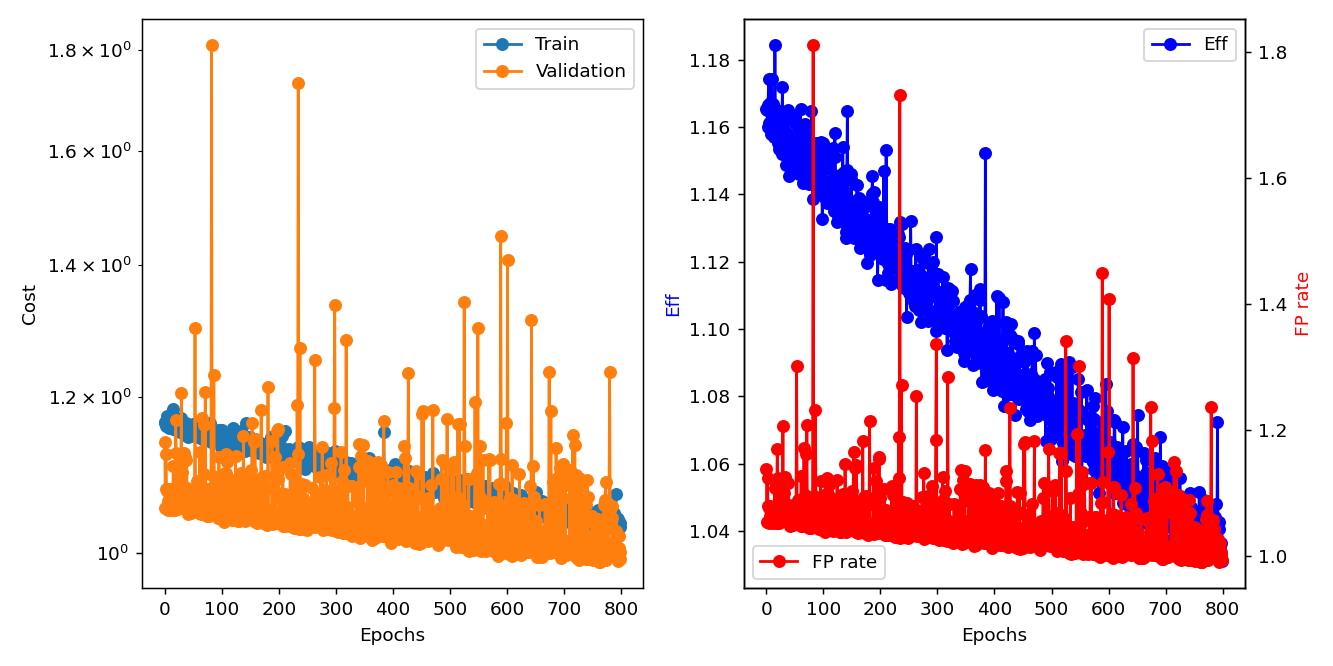

In [20]:
dual_train_plots(results.index,
                 results.cost, results.val,
                 results.cost, results.val)
plt.tight_layout()
plt.savefig(str(output / f'{name}_stats_a.png'))

In [22]:
##quit()
